Module config

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np

import scipy.stats as sp

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import savefig

Seaborn config

In [2]:
% matplotlib inline
sns.set(style='white')

Filesystem config

In [3]:
derivs = Path().absolute().parents[1] / 'derivatives'
source_dir = derivs / '0.4.joined'
alt_source_dir = derivs / '20190218'
figures_dir = derivs / 'figures'

Import data

In [4]:
data = pd.read_csv( source_dir / 'all_subject_level.csv' )
data = pd.read_csv( alt_source_dir / 'all_subject_level_bound.csv')

# Set standard variables to be analyzed

In [5]:
varset = {
    'dvars': [
        'comp_t1_bound',
        'comp_t2_bound',
        'comp_change_bound',
    ],
    'ivars': [
        'SciLit_sum_bound', 
        'vocab_sum_bound',
        'NFCS_sum_bound', 
        'TSSI_sum_bound', 
        'procspd_RT_bound',
        'nb_RT_bound',
    ],
}

ivars = list(varset['ivars'])
dvars = list(varset['dvars'])

# Demographics

In [6]:
(data.groupby(['AgeGroup', 'Condition'], as_index=False)
    .agg({'sub':'count', 'Age':'mean', 'Gender':'mean'})
    .rename({'sub':'Count', 'Age':'Mean Age', 'Gender':'% Female'}, axis=1))

,AgeGroup,Condition,Count,Mean Age,% Female
0,OA,Annotated,16,71.125000,0.687500
1,OA,Original,15,76.466667,0.733333
2,OA,Video,18,74.611111,0.611111
3,YA,Annotated,27,18.666667,0.666667
4,YA,Original,28,18.857143,0.500000
5,YA,Video,25,19.080000,0.640000


In [7]:
(data.groupby(['AgeGroup', 'Condition'], as_index=False)
    .agg({'sub':'count', 'comp_change':'mean', 'comp_t1':'mean', 'comp_t2':'mean'})
    .rename({'sub':'Count', 'comp_t1':'T1', 'comp_t2':'T2', 'comp_change':'Mean Diff'}, axis=1))

,AgeGroup,Condition,Count,Mean Diff,T1,T2
0,OA,Annotated,16,2.500000,11.250000,13.750000
1,OA,Original,15,3.400000,11.066667,14.466667
2,OA,Video,18,3.722222,10.555556,14.277778
3,YA,Annotated,27,2.814815,10.481481,13.296296
4,YA,Original,28,4.142857,9.607143,13.750000
5,YA,Video,25,3.800000,9.920000,13.720000


# Bound correlograms

I'm forced to drop null values before passing to `sns.pairplot()`, so we end up with fewer values:

In [8]:
pairplots_data = data[['AgeGroup', 'Condition'] + ivars + dvars]
print(
    pairplots_data.shape[0],'->',
    pairplots_data.dropna().shape[0]
)

142 -> 75


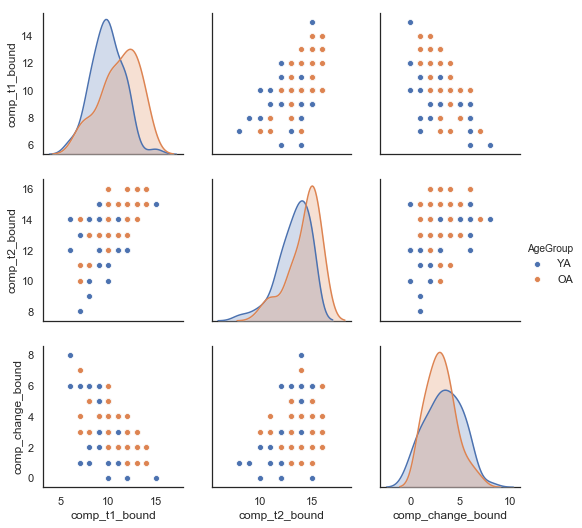

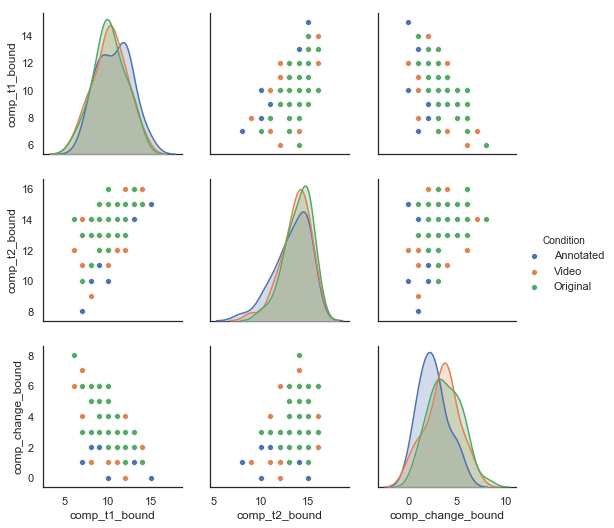

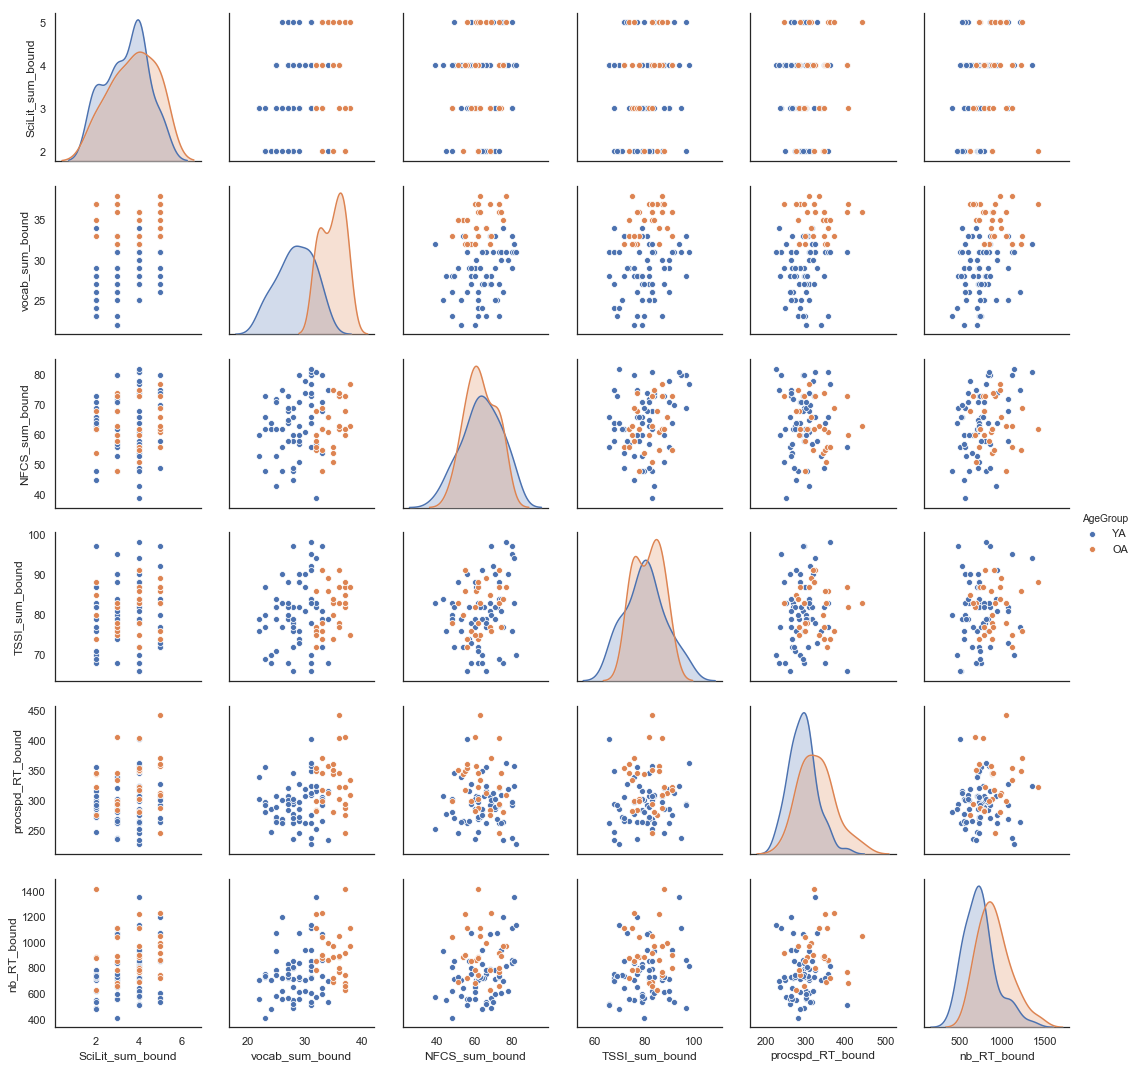

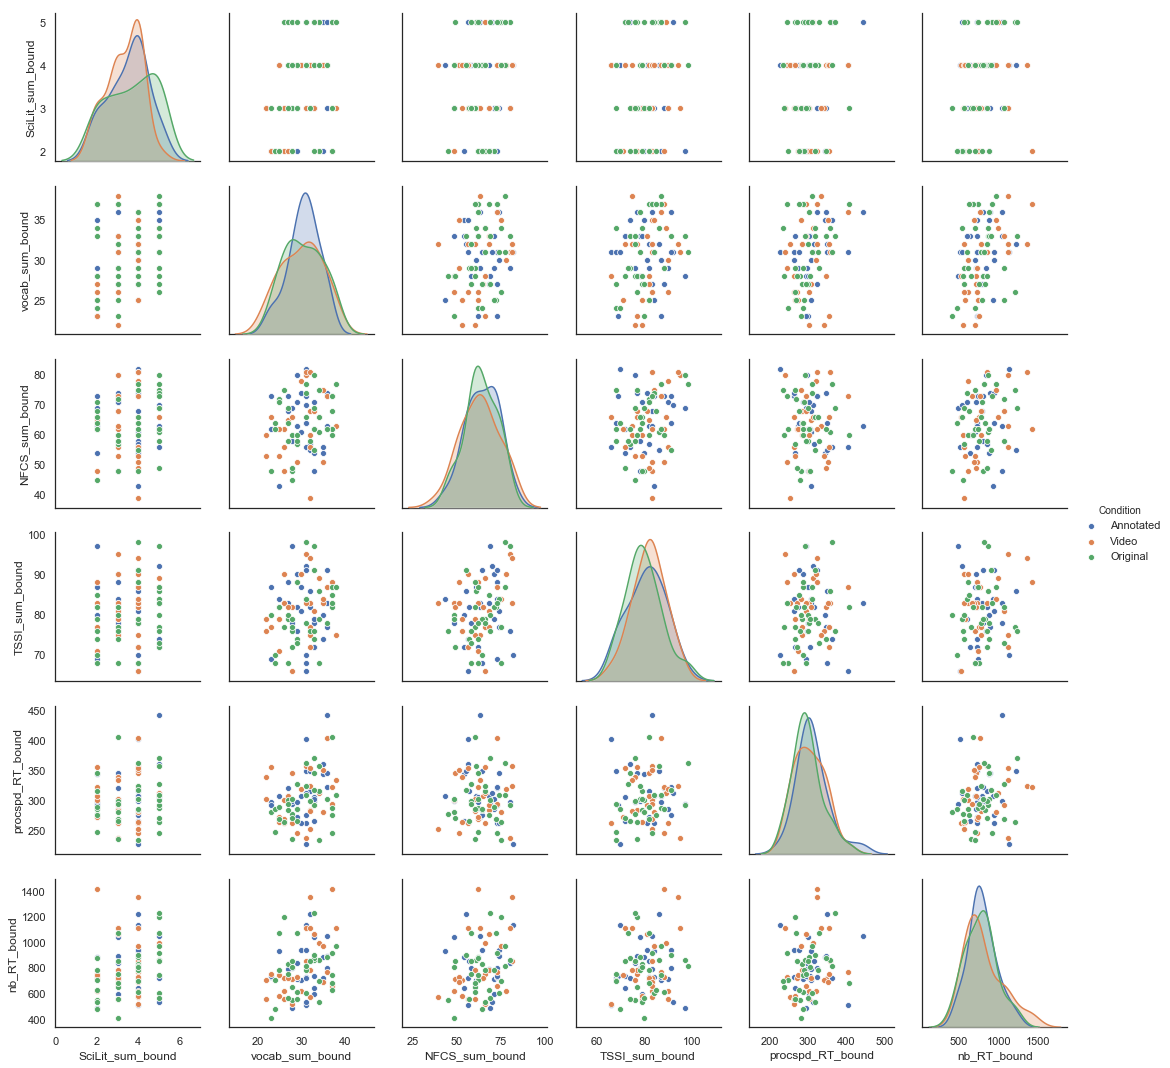

In [10]:
for v in varset.keys():
    for g in ('AgeGroup', 'Condition'):
        figpath = figures_dir / ('pairplot_' + v + '_by_' + g.lower() + '.png')
        pplot = sns.pairplot(data = data[ [g] + varset[v] ].dropna(), hue = g)
        pplot.savefig(figpath, bbox_inches = 'tight')


## Linear Model Plots

In [11]:
jitters = {
    'SciLit_sum_bound': 0.2,
}

c:\users\ia406477\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
c:\users\ia406477\appdata\local\programs\python\python37-32\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
c:\users\ia406477\appdata\local\programs\python\python37-32\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warnin

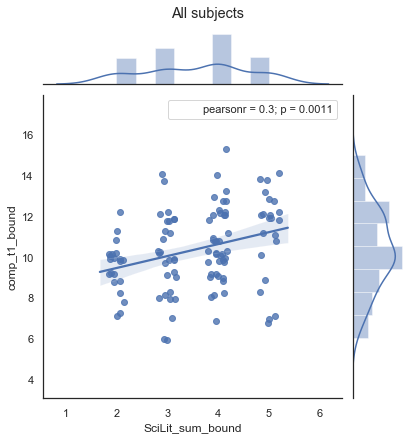

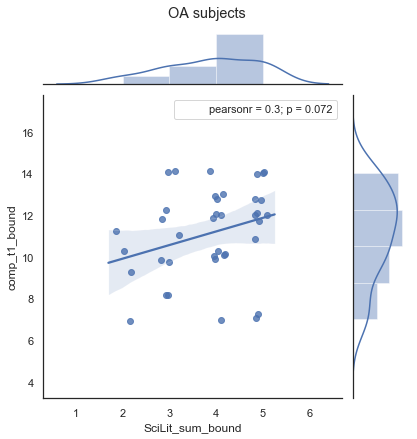

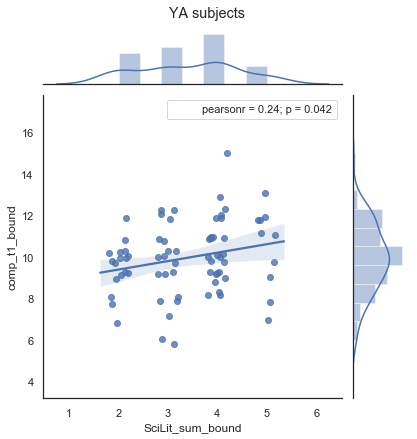

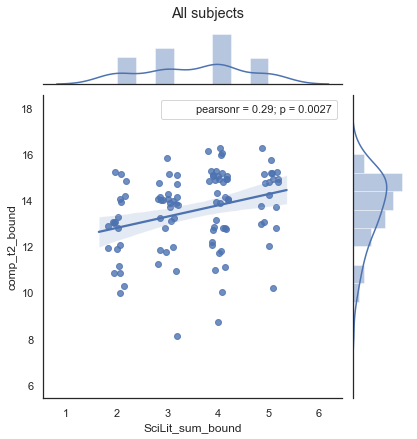

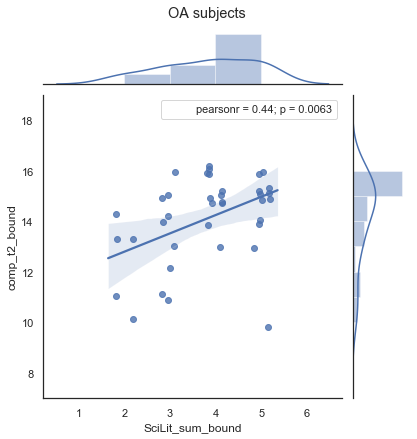

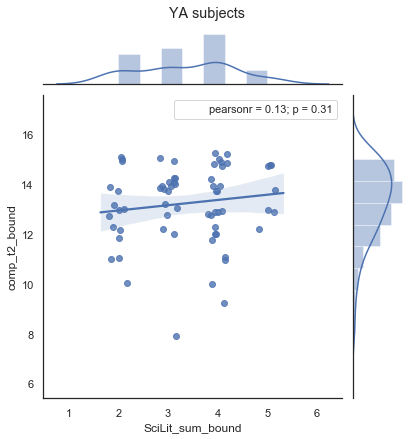

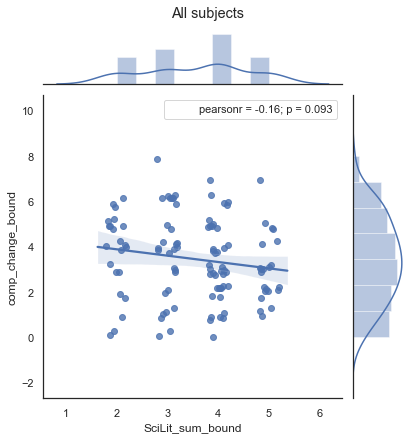

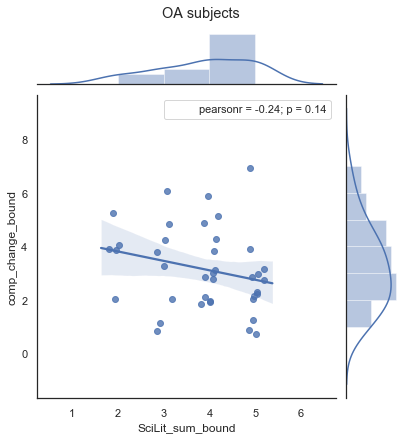

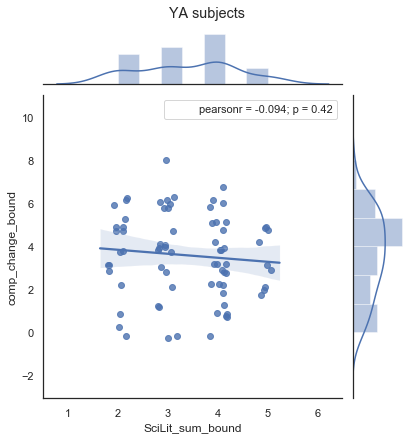

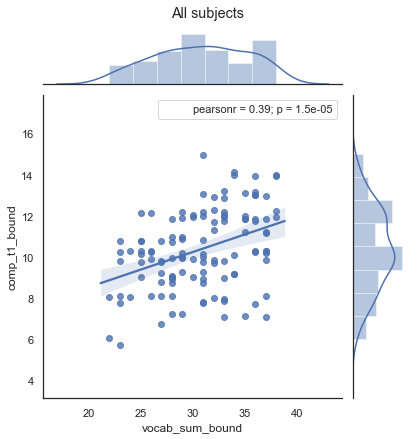

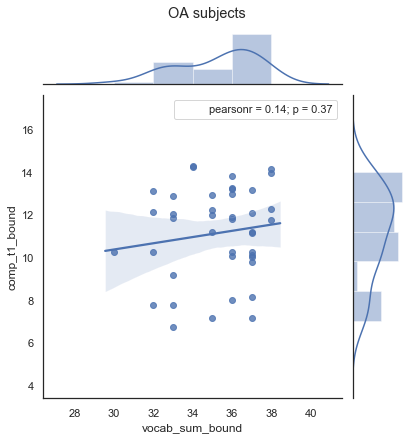

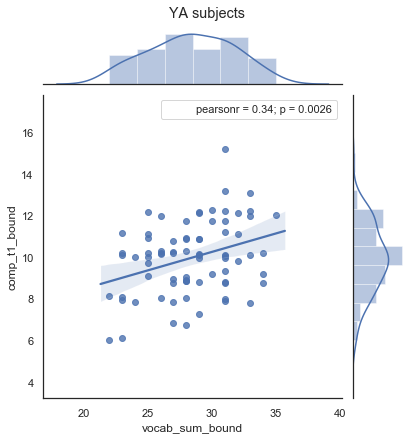

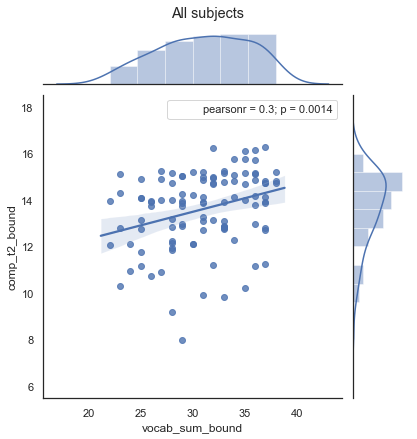

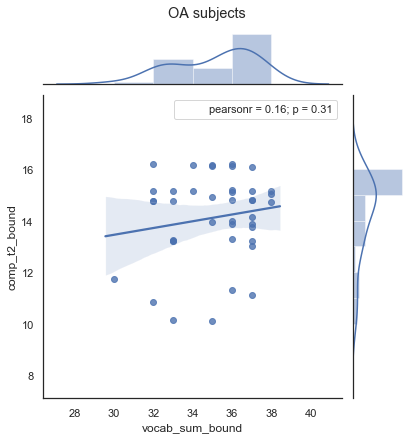

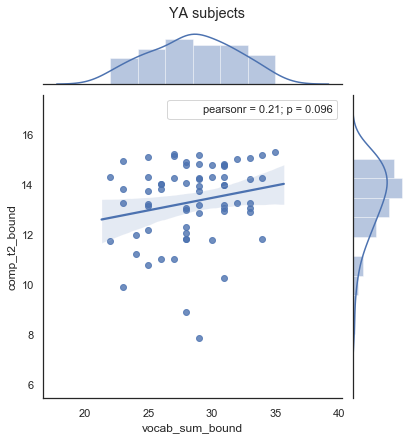

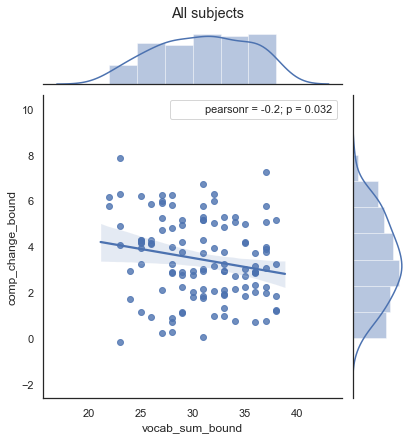

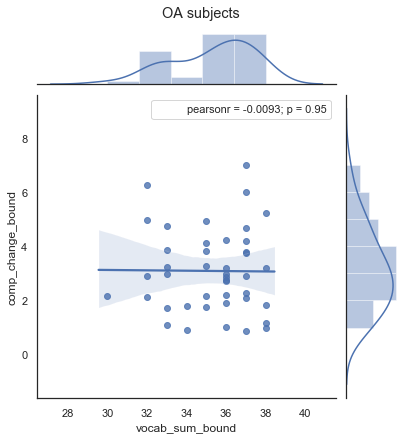

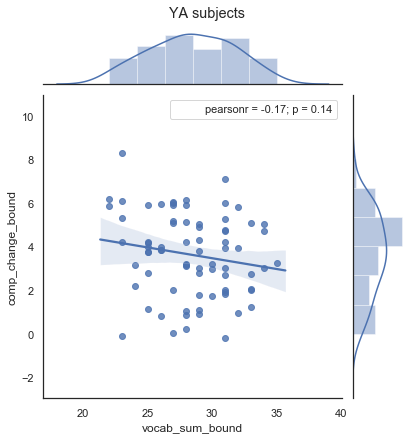

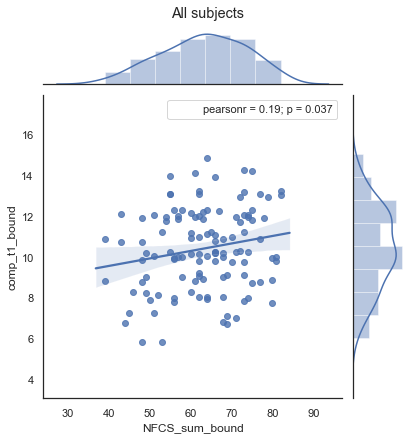

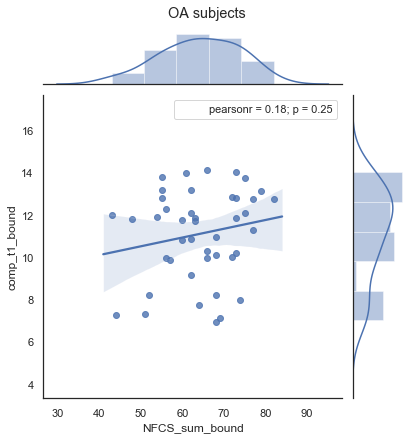

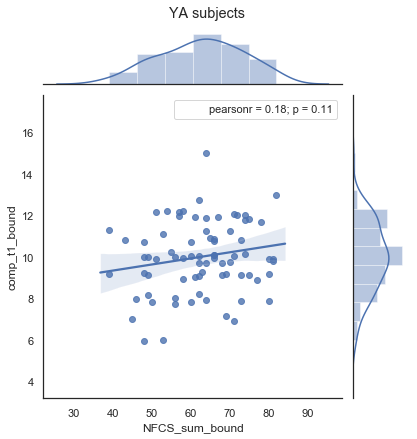

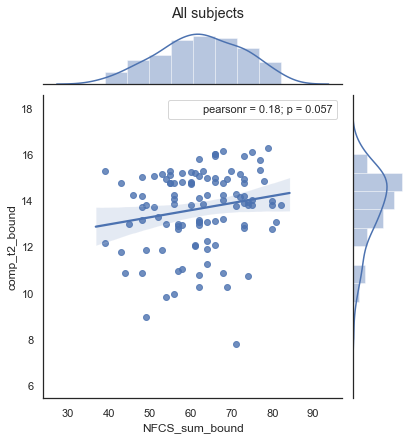

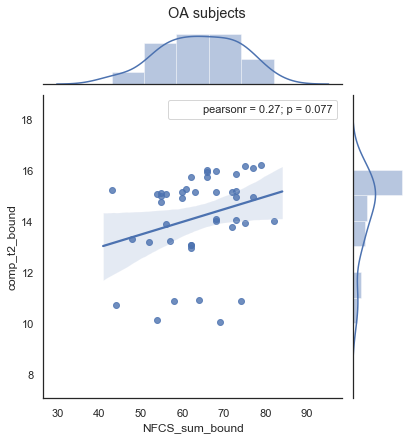

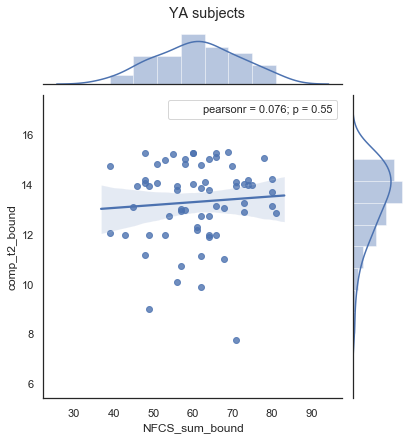

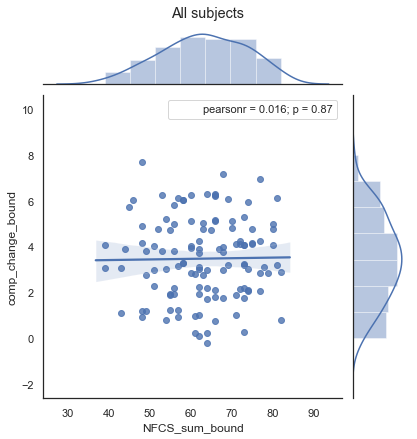

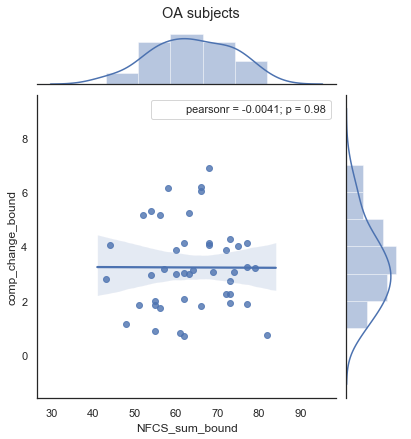

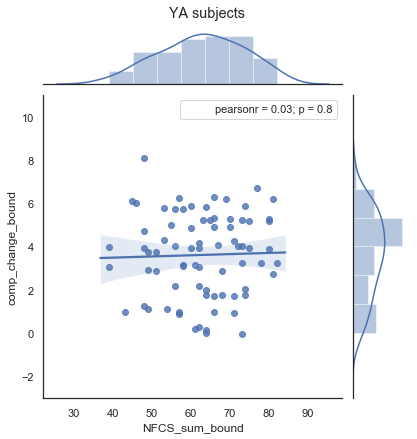

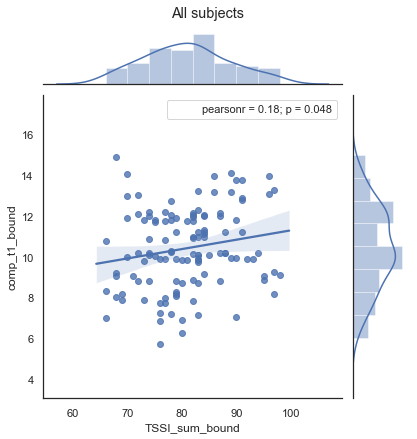

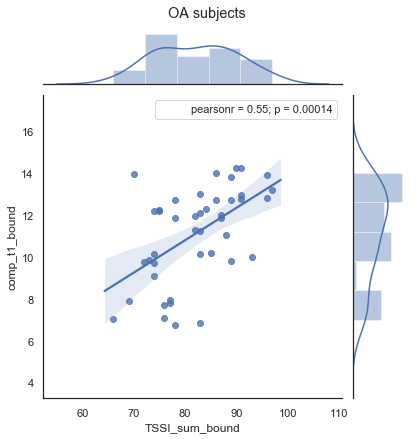

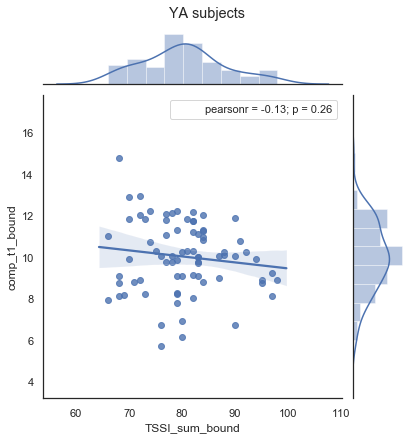

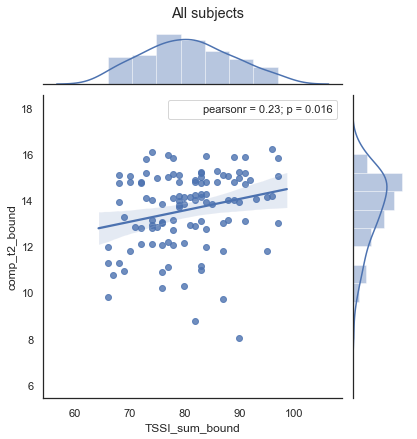

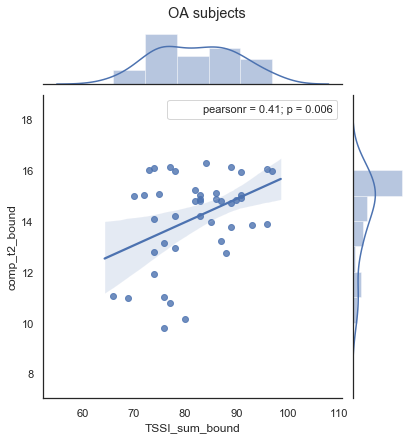

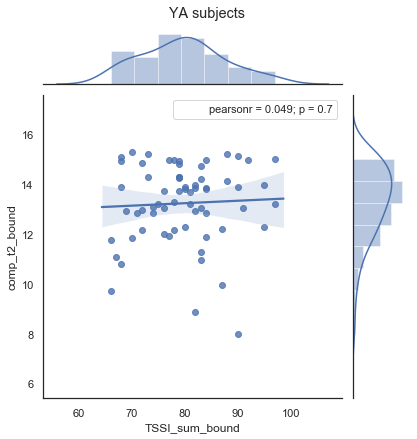

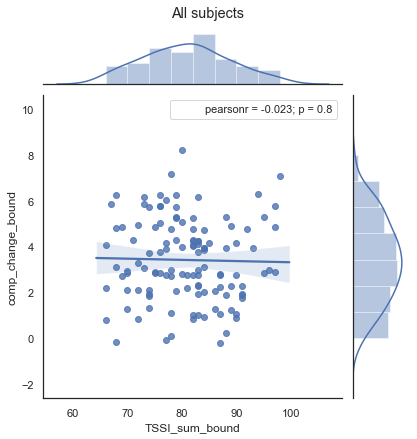

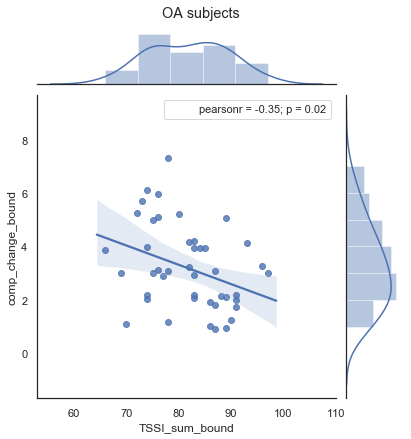

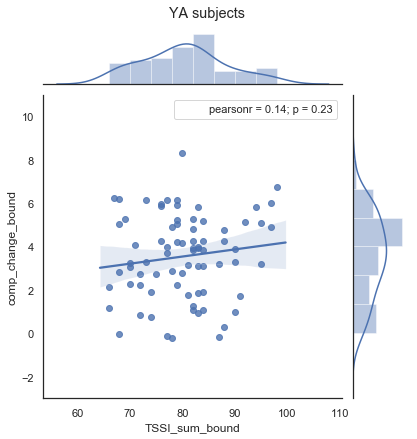

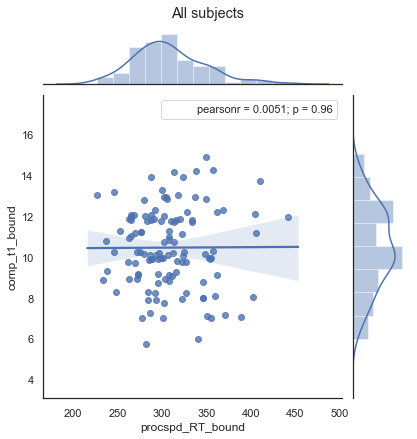

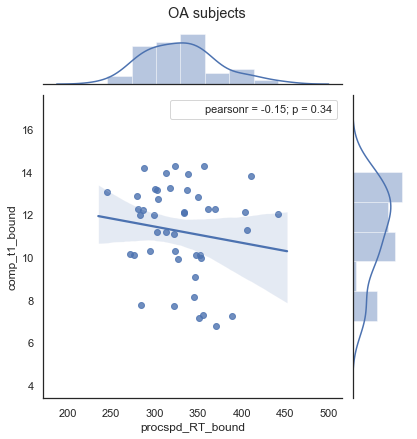

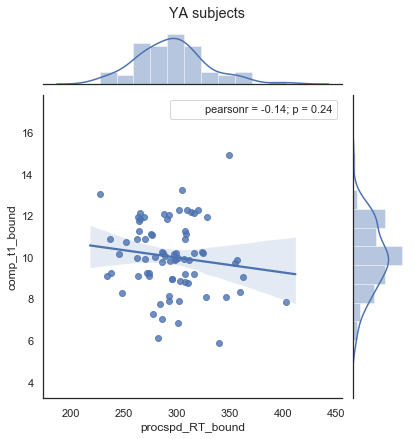

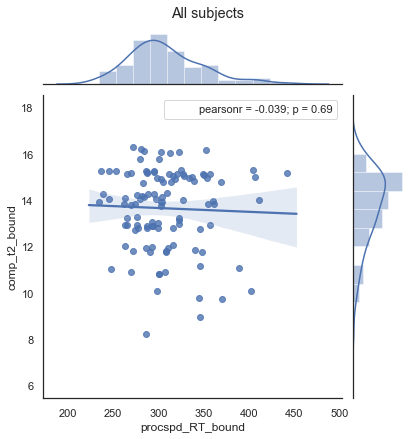

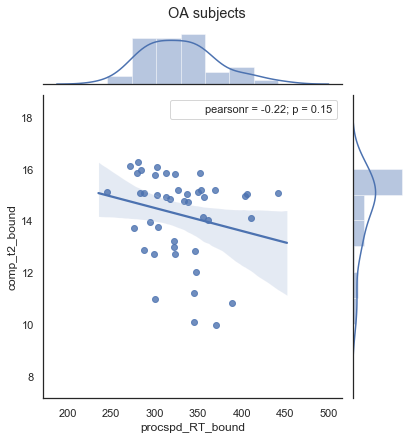

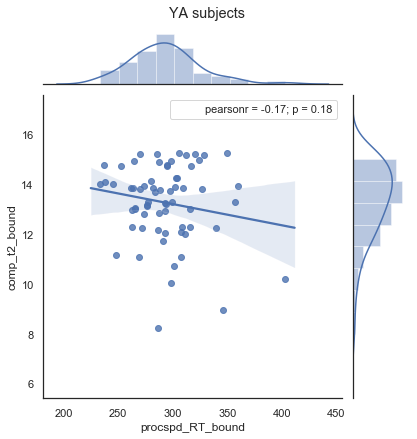

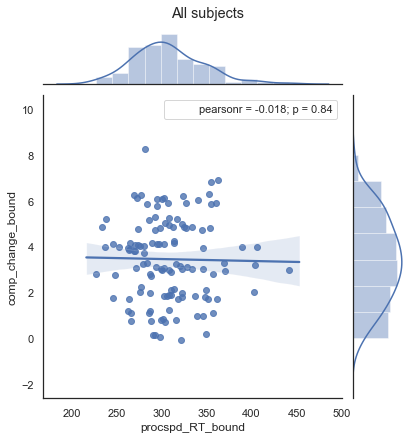

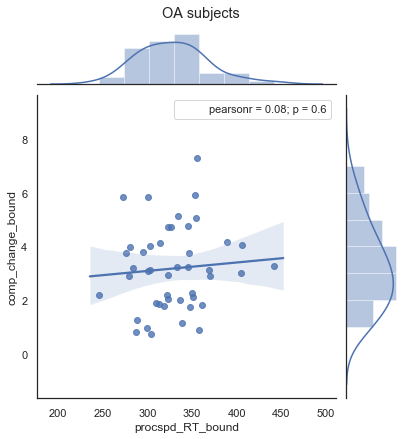

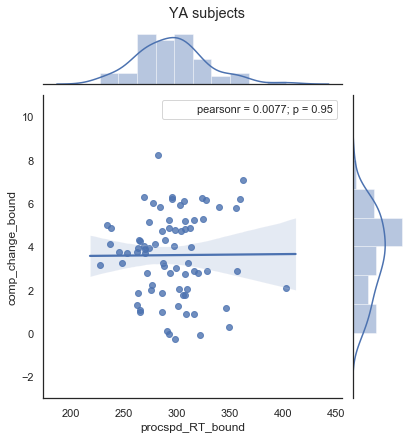

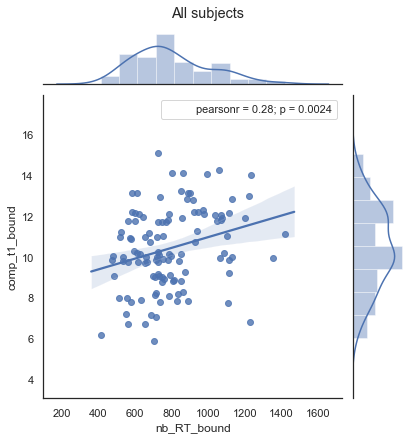

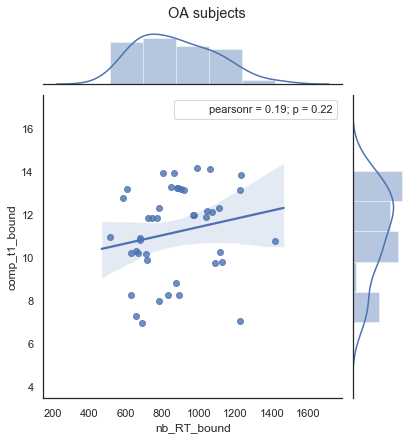

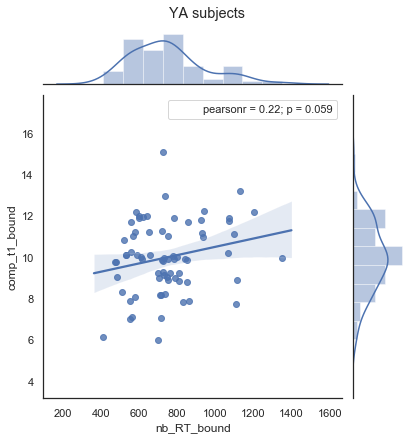

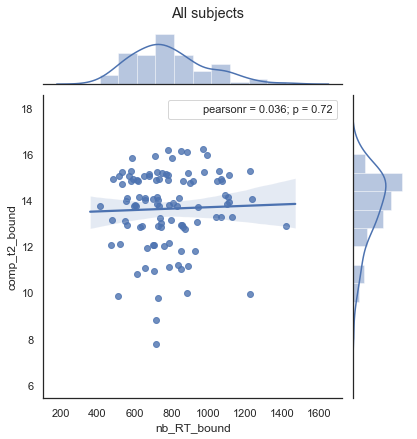

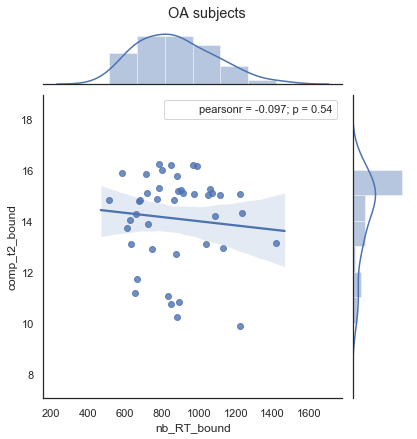

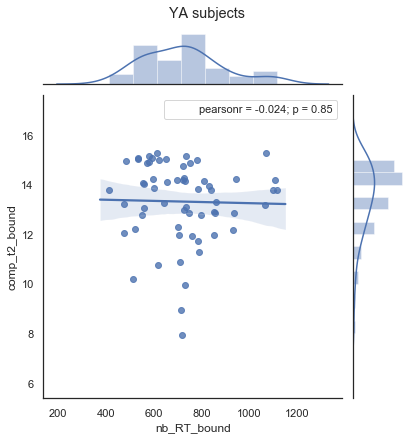

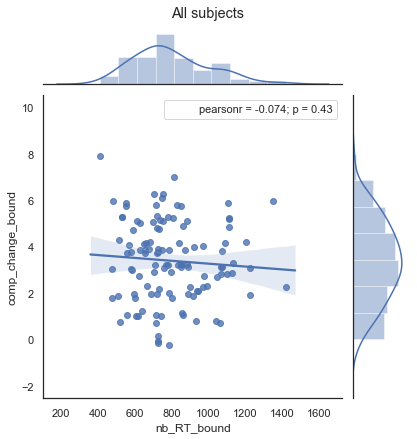

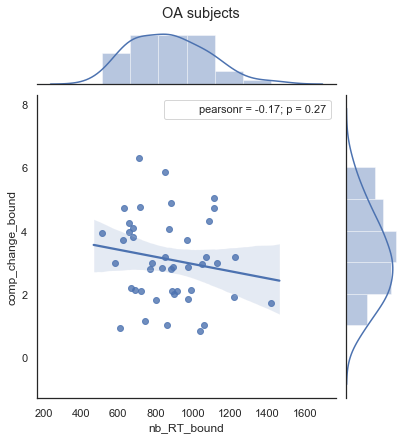

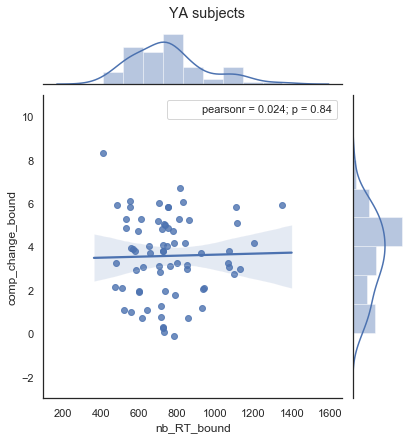

In [13]:
# Loop through predefined ivars and dvars
# to create individual bivariate relationship plots
for iv in ivars:
    for dv in dvars:
        
        # Select only the data we will use for each plot
        # Grouping var, IV, DV
        df = data[ [ 'AgeGroup' , iv , dv ] ]
        
        # Loop through model subsets and select only the data in the subset we want to analyze for each model
        for group in ('All', 'OA', 'YA'):
            if group is not 'All':
                # Select only OAs or YAs depending on the model
                jp_df = df.loc[df['AgeGroup'] == group]
            # Otherwise use the whole `df` as selected earlier
            else: jp_df = df
                
            # Use jitters dict to set the x_jitter on any IVs that are relatively discrete
            # We'll use the x_jitter parameter of `sns.regplot` to add some visual noise for those IVs
            # This doesn't affect the values being analyzed - only affects aesthetics of the plot
            if iv in jitters.keys():
                xj = jitters[iv]
            else: xj=None
            
            # Using a JointGrid object for reasons
            # Plotting the `regplot` & `distplot` separately so we can add visual noise
            # `JointGrid.annotate` method embeds the test results from `scipy.stats.pearsonr`
            g = sns.JointGrid(x = iv, y = dv, data = jp_df)
            g = g.plot_joint(sns.regplot, x_jitter=xj, y_jitter = 0.3)
            g = g.plot_marginals(sns.distplot)
            g = g.annotate(sp.pearsonr)
            
            # Add a `_suptitle` to the JointGrid
            g.fig.suptitle(t=(group + ' subjects'), y = 1.015)
            
            # Set the filename according to the plot's parameters and save
            figpath = figures_dir / ('joint_' + iv + '_' + dv + '_' + group + '.png')
            g.savefig(figpath)

# Horizontal Swarm, Strip, Box, Bar plots

In [15]:
plot_types = { 'swarm':sns.swarmplot, 'box':sns.boxplot, 'strip': sns.stripplot }
for p in plot_types.keys():
    for grpY in [['AgeGroup','Condition'], ['AgeGroup'], ['Condition']]:
        for varX in (ivars + dvars):
            df = (data.dropna(subset=grpY)
                      .set_index(grpY))

            fig = plot_types[p](data=df, x=varX, y=df.index)


            fname = varX + '_'+ ''.join(grpY) +'_'+ p +'.png'
            fpath = figures_dir / fname
            print(fpath)

            fig.get_figure().savefig(fpath, bbox_inches='tight')
            plt.clf()

print('Done!')

R:\experiments\scilearn\derivatives\figures\SciLit_sum_bound_AgeGroupCondition_swarm.png
R:\experiments\scilearn\derivatives\figures\vocab_sum_bound_AgeGroupCondition_swarm.png
R:\experiments\scilearn\derivatives\figures\NFCS_sum_bound_AgeGroupCondition_swarm.png
R:\experiments\scilearn\derivatives\figures\TSSI_sum_bound_AgeGroupCondition_swarm.png
R:\experiments\scilearn\derivatives\figures\procspd_RT_bound_AgeGroupCondition_swarm.png
R:\experiments\scilearn\derivatives\figures\nb_RT_bound_AgeGroupCondition_swarm.png
R:\experiments\scilearn\derivatives\figures\comp_t1_bound_AgeGroupCondition_swarm.png
R:\experiments\scilearn\derivatives\figures\comp_t2_bound_AgeGroupCondition_swarm.png
R:\experiments\scilearn\derivatives\figures\comp_change_bound_AgeGroupCondition_swarm.png
R:\experiments\scilearn\derivatives\figures\SciLit_sum_bound_AgeGroup_swarm.png
R:\experiments\scilearn\derivatives\figures\vocab_sum_bound_AgeGroup_swarm.png
R:\experiments\scilearn\derivatives\figures\NFCS_sum_bo

<Figure size 432x288 with 0 Axes>